In [1]:
@info("Loading packages")
using Pkg; Pkg.activate("../test")
using Plots, StatsPlots, Plots.Measures
using StatsBase
using Glob
using DataFrames, DataFramesMeta
using ProgressMeter
default(leg = false, lw = 1.5)

using ComponentArrays, StaticArrays
using Test
using Parameters
using Distributions
using OrdinaryDiffEq

┌ Info: Loading packages
└ @ Main c:\Users\simon\Documents\Julia\Hydra\test\abm.ipynb:1
  Activating project at `c:\Users\simon\Documents\Julia\Hydra\test`


In [2]:
# establishing type hierarchy
abstract type AbstractParams end
abstract type AbstractParamCollection end # an AbstractParamCollection contain a defined set of multiple AbstractParams instances
abstract type AbstractSpeciesParams <: AbstractParams end
abstract type AbstractGlobalParams <: AbstractParams end
abstract type AbstractABM end
abstract type AbstractAgent end

include("../src/DoseResponse.jl")
include("../src/Params.jl")
include("../src/Solvers.jl")
include("../src/StateVars.jl")
include("../src/IO.jl")
include("../src/ModelFunctions.jl")
include("../src/HydraODE.jl")
include("../src/ImpliedTraits.jl")
include("../src/Macros.jl")

@replicates

In [3]:
using Test

## ABM

In [4]:
abstract type AbstractABM end

"""
Currently assumes that all agents are represented by a single agent type `AgentType`.
"""
mutable struct ABM <: AbstractABM
    p::AbstractParamCollection # parameter collection
    t::Float64 # current simulation time
    dt::Float64 # timestep
    euler::Function # definition of the euler function for the given dt
    saveat::Float64
    
    u::ComponentVector # global state variables
    du::ComponentVector # global derivatives

    AgentID_count::Int64 # cumulative number of agents in the simulation
    agents::AbstractVector # population of agents
    aout::AbstractVector # agent output
    mout::AbstractVector # model output

    """
    Instantiate ABM from param collection `p`. 
    """
    function ABM(
        p::A; 
        dt = 1/24, 
        saveat = 1,
        execute = true,
        showprogress = false
        ) where A <: AbstractParamCollection

        abm = new() # initialize ABM object

        abm.p = p # store the parameters
        abm.t = 0. # initialize simulation time
        abm.dt = dt # timestep is given as keyword argument
        abm.euler = defeuler(dt) # Euler function for the given dt
        abm.saveat = saveat
        
        abm.u = init_substates_global(p) # initialize the global substates
        abm.du = similar(abm.u) # initialize the global derivatives
        abm.du.X_p = 0.
        abm.du.C_W .= 0.
        
        abm.AgentID_count = 0 # set agent count
        initialize_agents!(abm) # initailize the population of agents
        abm.aout = [] # initialize agent output
        abm.mout = [] # initialize model output

        if execute
            if showprogress
                runprogress!(abm)
            else
                run!(abm) # run the model
            end

            return prepare_output(abm) # prepare output in dataframes and return
        else
            return abm
        end
    end
end

ABM

In [5]:
using Random

"""
step!(abm::ABM; showprogress = false)

Execution of a generic ABM step, following the schedule: 

1. Shuffle agents
2. Calculate global derivatives
3. Calculate agent derivatives
4. Update agent states
5. Record agent states
6. Update global states
7. Record global states

It is important that the agent steps occur between calculation of the global derivatives and 
updating the global states, because global derivatives which may be influenced by agent derivatives 
are initialized during calculation of the global states and may be mutated by the agent step. <br>
Changing this order will lead to erroneous computation of the interaction between agents and the environment.

"""
function step!(abm::ABM)

    du, u, p = abm.du, abm.u, abm.p
    t = abm.t

    shuffle!(abm.agents)

    for func! in abm.p.glb.odefuncs # execute global ODE-based functions
        func!(du, u, p, t)
    end

    for func! in abm.p.glb.rulefuncs # execute global rule-based functions
        func!(abm)
    end
    
    for a in abm.agents # for every agent
        step!(a, abm) # execute agent steps
        record!(a, abm) # record agent data
    end

    map!(abm.euler, u, du, u) # apply the euler scheme to global states
    record!(abm) # record global states
    filter!(a -> a.u.agn.dead == false, abm.agents) # remove dead agents

    abm.t += abm.dt
end

step!

In [6]:
"""
    init_agents!(abm::AbstractABM)::nothing
Initialize the population of 
"""
function initialize_agents!(abm::AbstractABM)::Nothing

    abm.agents = [] # initialize a vector of agents with undefined values and defined length

    for i in 1:abm.p.glb.N0 # for the number of initial agents
        
        push!(abm.agents, abm.p.glb.AgentType(abm)) # initialize an agent and add it to the vector of agents
    end

    return nothing
end

initialize_agents!

## Agent

In [49]:
abstract type AbstractAgent end

function initialize_statevars!(agent::AbstractAgent)
    agent.u = ComponentVector(
        glb = init_substates_global(agent.p),
        agn = init_substates_agent(agent.p)
    )
end


"""
The definition of a generic AbstractAgent.
"""
mutable struct DEBAgent <: AbstractAgent
    p::AbstractParamCollection
    u::ComponentVector
    du::ComponentVector
    AgentID::Int64
    adata_t::AbstractVector

    """
        DEBAgent(abm::ABM)
    
    Initialization of a generic DEB agent within ABM structure.
    """
    function DEBAgent(abm::ABM)
        a = new()

        a.p = deepcopy(abm.p) # parameters; TODO: #29 avoid copying everything
        a.p.agn = AgentParams(a.p.spc) # assign agent-level parameters (induces individual variability)
        initialize_statevars!(a) # initialize agent-level state variables
        a.du = similar(a.u) # initialize agent-level derivatives
        a.du.glb = abm.du # reference to global derivatives
        a.du.agn = similar(a.u.agn) # derivatives of agent substates have same shape as states
        a.AgentID = abm.AgentID_count # assign AgentID
        abm.AgentID_count += 1 # increment AgentID counter
        
        return a
    end
end

DEBAgent

In [50]:
include("../src/ModelFunctions.jl")

N_tot! (generic function with 1 method)

In [83]:
"""
    update_glb!(agent::AbstractAgent, abm::AbstractABM)
    
Update an agent's reference to global state variables.
"""
function update_glb!(agent::AbstractAgent, abm::AbstractABM)
    map!(x -> x, agent.u.glb, abm.u) 
end

"""
    step!(agent::AbstractAgent, abm::AbstractABM; odefuncs::Vector{Function}, rulefuncs::Vector{Function})

Generic definition of agent step. \n
This definition is generic, so that the function body does not have to be modified 
in order to simulate different models.
"""
function step!(agent::AbstractAgent, abm::ABM)
    du, u, p = agent.du, agent.u, agent.p # unpack agent substates, derivatives and parameters
    t = abm.t

    update_glb!(agent, abm) # update references to global state variables
    
    for func! in agent.p.spc.rulefuncs # apply all rule-based functions
        func!(agent, abm)
    end

    for func! in agent.p.spc.odefuncs # apply all ODE-based functions
        func!(du, u, p, t) 
    end


    map!(abm.euler, u.agn, du.agn, u.agn) # apply the euler scheme to agent substates
end

"""
    record!(agent::DEBAgent, abm::ABM)

Record agent output (only if `p.glb.recordagentvars == true`).
"""
function record!(agent::AbstractAgent, abm::ABM)
    if isapprox(abm.t%abm.saveat, 0, atol = abm.dt) && abm.p.glb.recordagentvars
        push!(abm.aout, (t = abm.t, AgentID = agent.AgentID, u = deepcopy(agent.u.agn)))
    end
end


record!

In [85]:
using ProgressMeter

"""
    record!(abm::ABM)

Record model-level output.
"""
function record!(abm::ABM)
    if isapprox(abm.t%abm.saveat, 0, atol = abm.dt)
        push!(abm.mout, (t = abm.t, u = deepcopy(abm.u)))
    end
end

"""
    run!(abm::AbstractABM)

Run the ABM.
"""
function run!(abm::AbstractABM)
    while abm.t <= abm.p.glb.t_max
        step!(abm)
    end
end


"""
    run!(abm::AbstractABM)
    
Run the ABM and show a progress bar.
"""
function runprogress!(abm::AbstractABM)
    num_steps = ceil(abm.t / abm.dt)

    @showprogress for step in 1:num_steps
        step!(abm)
    end
end

runprogress!

In [86]:
"""
    prepare_output(abm::AbstractABM)

Prepare ABM output, converting Vectors of ComponentArrays into DataFrames. 
Two separate DataFrames are returned containing global and agent-level state variables, respectively.
"""
function prepare_output(abm::AbstractABM)

    mout = DataFrame(hcat([[x.t] for x in abm.mout]...)', [:t]) |> 
    x-> hcat(x, DataFrame(hcat([m.u for m in abm.mout]...)', extract_colnames(abm.mout[1].u)))
    
    if abm.p.glb.recordagentvars
        aout = DataFrame(hcat([[x.t, x.AgentID] for x in abm.aout]...)', [:t, :AgentID]) |> 
        x-> hcat(x, DataFrame(hcat([a.u for a in abm.aout]...)', extract_colnames(abm.aout[1].u)))
    else
        aout = DataFrame()
    end

    return mout, aout
end

prepare_output

In [87]:
theta = ABMParamCollection(
    glb = GlobalABMParams(AgentType = DEBAgent)
)

push!(theta.spc.rulefuncs, ingestion!)
theta.glb.rulefuncs = [N_tot!]

1-element Vector{typeof(N_tot!)}:
 N_tot! (generic function with 1 method)

  4.709321 seconds (75.87 M allocations: 1.721 GiB, 3.78% gc time, 1.86% compilation time)


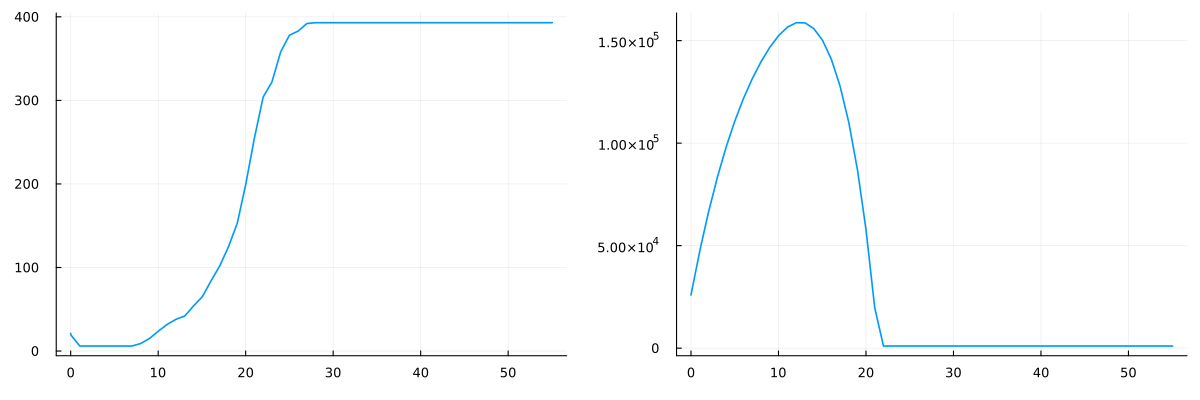

In [197]:
theta.glb.N0 = 21.
theta.glb.t_max = 56.
theta.glb.Xdot_in = 1250. * 20.
theta.glb.k_V = 0.1 # chemostat dilution rate
theta.glb.V_patch = 0.5

theta.spc.K_X 

@time Yhat_m, Yhat_a = ABM(theta)

pm = @df Yhat_m plot(
    plot(:t, :N_tot),
    plot(:t, :X_p)
)

pa = @df Yhat_a plot(
    plot(:t, :S, group = :AgentID)
)

# FIXME: 

plot(pm, size = (1200,400), thickness_scaling = 1.1, bottommargin = 5mm)

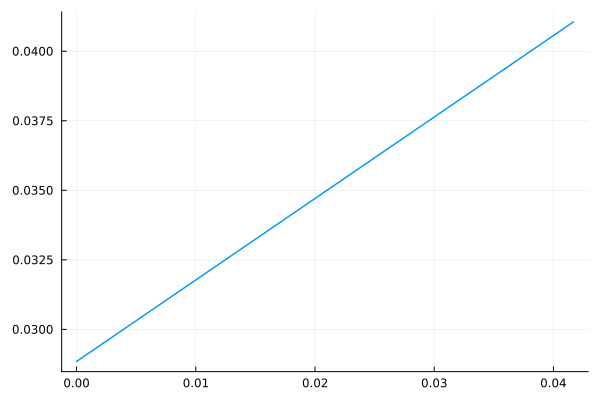

In [35]:
@df @subset(Yhat_a, :AgentID .== 6) plot(:t, :S)

In [23]:
using CSV
CSV.write("adata.csv", Yhat_a)

"adata.csv"

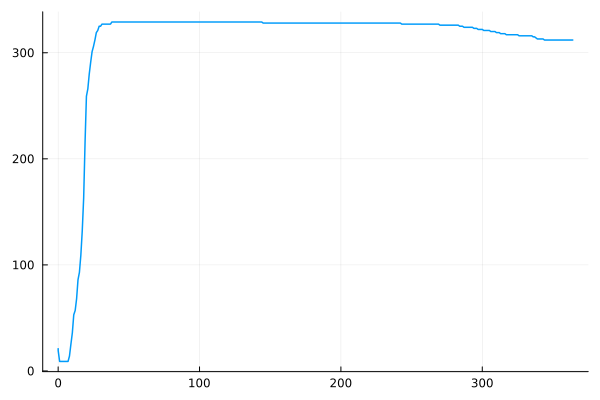

In [15]:
@df Yhat_m plot(:t, :N_tot)

In [27]:
Yhat_a.causeofdeath |> countmap

Dict{Float64, Int64} with 2077 entries:
  1.81961e-309 => 1
  9.53913e-310 => 1
  1.66888e-309 => 1
  2.526e-309   => 1
  2.81467e-310 => 1
  1.73937e-309 => 1
  9.77792e-310 => 1
  3.67011e-309 => 1
  2.16604e-309 => 1
  2.73781e-311 => 1
  4.93461e-310 => 1
  3.37039e-309 => 1
  1.52309e-309 => 1
  3.29451e-309 => 1
  3.45494e-309 => 1
  8.96151e-310 => 1
  1.45681e-309 => 1
  2.89064e-309 => 1
  7.7839e-311  => 1
  ⋮            => ⋮

In [14]:
theta.glb.t_max = 365.
@time Yhat_m, Yhat_a = ABM(theta)

 42.912905 seconds (585.01 M allocations: 13.140 GiB, 4.56% gc time, 1.02% compilation time)


(366×4 DataFrame
 Row │ t            X_p            C_W_1    N_tot   
     │ Float64      Float64        Float64  Float64 
─────┼──────────────────────────────────────────────
   1 │   0.0        25937.5            0.0     21.0
   2 │   0.0416667  26871.1            0.0     19.0
   3 │   1.04167    48146.8            0.0      9.0
   4 │   2.0        66183.2            0.0      9.0
   5 │   3.04167    83246.8            0.0      9.0
   6 │   4.04167    97327.1            0.0      9.0
   7 │   5.0            1.08873e5      0.0      9.0
   8 │   6.0            1.19087e5      0.0      9.0
  ⋮  │      ⋮             ⋮           ⋮        ⋮
 360 │ 358.0         1037.34           0.0    312.0
 361 │ 359.0         1037.34           0.0    312.0
 362 │ 360.0         1037.34           0.0    312.0
 363 │ 361.0         1037.34           0.0    312.0
 364 │ 362.0         1037.34           0.0    312.0
 365 │ 363.0         1037.34           0.0    312.0
 366 │ 364.0         1037.34           0.0    3